In [5]:
from dataclasses import dataclass, InitVar, field
from functools import partial
from typing import Any, Tuple, Optional

import numpy
from matplotlib import pyplot, cm, colors

from pyioflash import SimulationData

In [6]:
def _contourp(ax, x, y, z, **kwargs):
    ax.contour(x, y, z, alpha=1.0, **kwargs)
    return ax.contourf(x, y, z, alpha=0.5, **kwargs)

def _make_figure(figure, axis):
    if figure is None or axis is None:
        return pyplot.subplots(figsize=(14, 9))
    else:
        return figure, axis
    
def _plot2D(x, y, z, figure = None, axis = None, **options):
    
    fig, ax = _make_figure(figure, axis)
    plot = PlotOptions(ax, z, 2, **options)
    cax = _render_byBlocks(plot, x, y, z)
    _set_plot_labels(ax, plot)
    _set_colorbar(fig, ax, cax, plot)

def _render_byBlocks(plot, xx, yy, zz):
    cax = {}
    for b, (x, y, z) in enumerate(zip(*(plot._order(item) for item in (xx, yy, zz)))):
        cax[b] = plot._plot(x, y, z)
    return cax

def _set_colorbar(figure, axis, artists, plot):
    if plot.colorbar:  
        figure.colorbar(artists[0], ax=axis, ticks=plot._lvls[::plot.colorbar_skip])

def _set_plot_labels(axis, plot):
    axis.set_title(plot.title, fontsize=plot.font_size, fontfamily=plot.font_face)
    axis.set_xlabel(plot._lbls[0], fontsize=plot.font_size, fontfamily=plot.font_face)
    axis.set_ylabel(plot._lbls[1], fontsize=plot.font_size, fontfamily=plot.font_face);
    
@dataclass
class PlotOptions:
    plot_axis: InitVar[Optional[Any]] = None
    plot_field: InitVar[Optional[Any]] = None
    plot_orientation: InitVar[Optional[int]] = 2
    title: str = ''
    labels: Tuple[str, str, str] = ('x [-]', 'y [-]', 'z [-]')
    font_size: int = 12
    font_face: str = 'DejaVu Sans'
    method: str = 'contour+'
    reverse: bool = True
    colorbar: bool = True
    colorbar_skip: int = 8
    colormap: str = 'viridis'
    vrange: Optional[Tuple[float, float]] = None
    vrange_auto: Optional[bool] = True
    vrange_ext: str = 'neither'
    contours_lvls: int = 81
    contours_skip: int = 4
    contours_alpha: float = 1.0
        
    def __post_init__(self, plot_axis, plot_field, plot_orientation):
        
        # Determine the vrange if plot_field provided
        if self.vrange is None and plot_field is not None:
            if self.vrange_auto:
                ext = numpy.min(plot_field), numpy.max(plot_field)
                sgn = numpy.sign(ext)
                ext = numpy.abs(ext)
                pwr = numpy.log10(ext+1E-6)
                mag = numpy.round(10**(pwr - numpy.floor(pwr)))
                self.vrange = tuple(sgn * mag * 10**numpy.floor(pwr))
            else:
                self.vrange = (numpy.min(plot_field), numpy.max(plot_field)) 
                
        # Determine additional Plot Properties
        self._cmap = getattr(cm, self.colormap)
        self._lbls = tuple(self.labels[ax] for ax in {0: (1, 2), 1: (0, 1), 2: (0, 1)}[plot_orientation])        
        self._order = {True: reversed, False: lambda _: _}[self.reverse]
        if self.vrange is not None:
            self._lvls = numpy.linspace(self.vrange[0], self.vrange[1], self.contours_lvls)
            self._norm = colors.Normalize(vmin=self.vrange[0], vmax=self.vrange[1])

        # Determine appropriate plot function if able
        if plot_axis is not None and self.vrange is not None:
            self._plot = {
                'contour': partial(plot_axis.contour, levels=self._lvls[::self.contours_skip],
                                   vmin=self.vrange[0], vmax=self.vrange[1], extend=self.vrange_ext,
                                   norm=self._norm, cmap=self._cmap, alpha=self.contours_alpha),
                
                'contourf': partial(plot_axis.contourf, levels=self._lvls[::self.contours_skip],
                                    vmin=self.vrange[0], vmax=self.vrange[1], extend=self.vrange_ext,
                                    norm=self._norm, cmap=self._cmap, alpha=self.contours_alpha),
                
                'density': partial(plot_axis.pcolormesh, 
                                   vmin=self.vrange[0], vmax=self.vrange[1],
                                   norm=self._norm, cmap=self._cmap, antialiased=True),
                
                'contour+': partial(_contourp, plot_axis, 
                                    levels=self._lvls[::self.contours_skip],
                                    vmin=self.vrange[0], vmax=self.vrange[1], extend=self.vrange_ext,
                                    norm=self._norm, cmap=self._cmap)
                         }[self.method]
        


############    Building SImulationData Object   ############

Processing metadata from: data/INS_Rayleigh_hdf5_plt_cnt_0000
Reading Grid from File
Processing file: data/INS_Rayleigh_hdf5_plt_cnt_0020

#############################################################




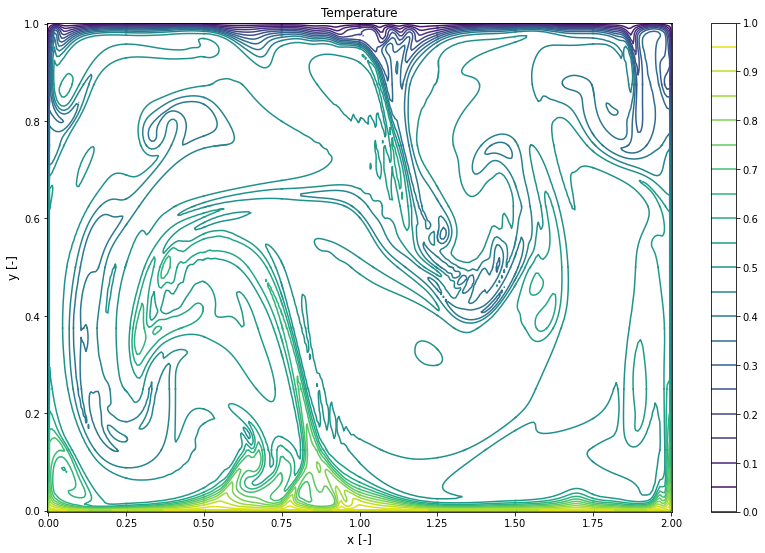

In [7]:
data = SimulationData.from_list(range(21), path='data/', basename='INS_Rayleigh_', header='hdf5_plt_cnt_')

xx, yy = data.geometry._grd_mesh_x[1, :, 1, :, :], data.geometry._grd_mesh_y[1, :, 1, :, :]
u, v, T = data.fields['_fcx2', '_fcy2', '_temp'][-1, :, 1, :, :]

_plot2D(xx, yy, T, title='Temperature', method='contour')

In [8]:
PlotOptions()

PlotOptions(title='', labels=('x [-]', 'y [-]', 'z [-]'), font_size=12, font_face='DejaVu Sans', method='contour+', reverse=True, colorbar=True, colorbar_skip=8, colormap='viridis', vrange=None, vrange_auto=True, vrange_ext='neither', contours_lvls=81, contours_skip=4, contours_alpha=1.0)